In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/psc-data/ML_Data.csv


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
import tensorflow as tf
from scipy.stats import skew

# Load dataset
file_path = "/kaggle/input/psc-data/ML_Data.csv"
data = pd.read_csv(file_path)

# Handle NaN values - fill with mean for numerical and mode for categorical
data.fillna(data.mean(numeric_only=True), inplace=True)
data.fillna(data.mode().iloc[0], inplace=True)

# Check for skewness in numerical features
skewness = data.skew(numeric_only=True)
skewed_features = skewness[abs(skewness) > 0.5].index

# Log transform to reduce skewness
for feature in skewed_features:
    data[feature] = np.log1p(data[feature])

# Selected features
features = ['ETL electron affinity(eV)','Rshunt (ohm cm2)','VOC(V)', 'JSC(mA/cm2)', 'FF(%)']
target = 'PCE(%)'

# Split data into features and target
X = data[features]
y = data[target]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# KFold cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def build_and_compile_model(loss_function):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss=loss_function, 
                  metrics=[MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Placeholder for the results
results = []

for train_index, test_index in kf.split(X_preprocessed):
    X_train, X_test = X_preprocessed[train_index], X_preprocessed[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Reshape data for LSTM input
    X_train_reshaped = np.expand_dims(X_train, axis=2)
    X_test_reshaped = np.expand_dims(X_test, axis=2)
    
    # Models for different loss functions
    model_mae = build_and_compile_model(MeanAbsoluteError())
    model_mse = build_and_compile_model(MeanSquaredError())
    model_huber = build_and_compile_model(Huber())
    
    # Train the models
    history_mae = model_mae.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    history_mse = model_mse.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    history_huber = model_huber.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate models
    for name, model in zip(['MAE', 'MSE', 'Huber'], [model_mae, model_mse, model_huber]):
        y_pred = model.predict(X_test_reshaped)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name, 
            'MAE': mae, 
            'MSE': mse, 
            'RMSE': rmse, 
            'R2 Score': r2,
            'Fold': len(results) + 1
        })


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [15]:

# Convert results to DataFrame
results_df = pd.DataFrame(results)


print(results_df)



    Model       MAE       MSE      RMSE  R2 Score  Fold
0     MAE  0.055491  0.018589  0.136341  0.997328     1
1     MSE  0.061341  0.020691  0.143842  0.997026     2
2   Huber  0.054181  0.017630  0.132776  0.997466     3
3     MAE  0.083446  0.053506  0.231314  0.992601     4
4     MSE  0.088089  0.027414  0.165572  0.996209     5
5   Huber  0.075803  0.021519  0.146694  0.997024     6
6     MAE  0.068626  0.025913  0.160974  0.996301     7
7     MSE  0.081655  0.047962  0.219002  0.993153     8
8   Huber  0.052888  0.019544  0.139800  0.997210     9
9     MAE  0.068197  0.015326  0.123798  0.997772    10
10    MSE  0.065576  0.018334  0.135404  0.997334    11
11  Huber  0.061247  0.014547  0.120609  0.997885    12
12    MAE  0.067296  0.027822  0.166800  0.996112    13
13    MSE  0.076007  0.027347  0.165369  0.996178    14
14  Huber  0.077259  0.036340  0.190630  0.994921    15
15    MAE  0.056671  0.021255  0.145790  0.997016    16
16    MSE  0.057504  0.024743  0.157301  0.99652

In [16]:
# Calculate percentage differences for MSE (D1, D2, D3)
# Assuming k2 corresponds to Fold 2, k4 to Fold 4, k5 to Fold 5, and k10 to Fold 10.

# Fetch the MSE values for corresponding folds
k2_mse = results_df[results_df['Fold'] == 2]['MSE'].values[0]
k4_mse = results_df[results_df['Fold'] == 4]['MSE'].values[0]
k5_mse = results_df[results_df['Fold'] == 5]['MSE'].values[0]
k10_mse = results_df[results_df['Fold'] == 10]['MSE'].values[0]

# Calculate D1(%), D2(%), and D3(%)
D1 = ((k4_mse - k2_mse) / k2_mse) * 100
D2 = ((k5_mse - k4_mse) / k4_mse) * 100
D3 = ((k10_mse - k5_mse) / k5_mse) * 100

# Create a summary table for the percentage differences
diff_table = pd.DataFrame({
    'Performance Type': ['MSE'],
    'k2': [k2_mse],
    'k4': [k4_mse],
    'k5': [k5_mse],
    'k10': [k10_mse],
    'D1(%)': [D1],
    'D2(%)': [D2],
    'D3(%)': [D3]
})

# Display the table with percentage differences
print(diff_table)


  Performance Type        k2        k4        k5       k10       D1(%)  \
0              MSE  0.020691  0.053506  0.027414  0.015326  158.601422   

       D2(%)      D3(%)  
0 -48.764645 -44.094442  


In [17]:
# Fetch the values for corresponding folds
k2_mae = results_df[results_df['Fold'] == 2]['MAE'].values[0]
k4_mae = results_df[results_df['Fold'] == 4]['MAE'].values[0]
k5_mae = results_df[results_df['Fold'] == 5]['MAE'].values[0]
k10_mae = results_df[results_df['Fold'] == 10]['MAE'].values[0]

k2_mse = results_df[results_df['Fold'] == 2]['MSE'].values[0]
k4_mse = results_df[results_df['Fold'] == 4]['MSE'].values[0]
k5_mse = results_df[results_df['Fold'] == 5]['MSE'].values[0]
k10_mse = results_df[results_df['Fold'] == 10]['MSE'].values[0]

k2_rmse = results_df[results_df['Fold'] == 2]['RMSE'].values[0]
k4_rmse = results_df[results_df['Fold'] == 4]['RMSE'].values[0]
k5_rmse = results_df[results_df['Fold'] == 5]['RMSE'].values[0]
k10_rmse = results_df[results_df['Fold'] == 10]['RMSE'].values[0]

# Calculate percentage differences for MAE, MSE, RMSE
D1_mae = ((k4_mae - k2_mae) / k2_mae) * 100
D2_mae = ((k5_mae - k4_mae) / k4_mae) * 100
D3_mae = ((k10_mae - k5_mae) / k5_mae) * 100

D1_mse = ((k4_mse - k2_mse) / k2_mse) * 100
D2_mse = ((k5_mse - k4_mse) / k4_mse) * 100
D3_mse = ((k10_mse - k5_mse) / k5_mse) * 100

D1_rmse = ((k4_rmse - k2_rmse) / k2_rmse) * 100
D2_rmse = ((k5_rmse - k4_rmse) / k4_rmse) * 100
D3_rmse = ((k10_rmse - k5_rmse) / k5_rmse) * 100

# Create a summary table for the percentage differences for all metrics
diff_table = pd.DataFrame({
    'Performance Type': ['MAE', 'MSE', 'RMSE'],
    'k2': [k2_mae, k2_mse, k2_rmse],
    'k4': [k4_mae, k4_mse, k4_rmse],
    'k5': [k5_mae, k5_mse, k5_rmse],
    'k10': [k10_mae, k10_mse, k10_rmse],
    'D1(%)': [D1_mae, D1_mse, D1_rmse],
    'D2(%)': [D2_mae, D2_mse, D2_rmse],
    'D3(%)': [D3_mae, D3_mse, D3_rmse]
})

# Display the table with percentage differences for all metrics
print(diff_table)


  Performance Type        k2        k4        k5       k10       D1(%)  \
0              MAE  0.061341  0.083446  0.088089  0.068197   36.037690   
1              MSE  0.020691  0.053506  0.027414  0.015326  158.601422   
2             RMSE  0.143842  0.231314  0.165572  0.123798   60.810889   

       D2(%)      D3(%)  
0   5.563801 -22.582060  
1 -48.764645 -44.094442  
2 -28.421124 -25.229981  


In [20]:
# Fetch the values for corresponding folds (k2, k4, k5, k10) for MAE, MSE, RMSE, and R2 Score
k2_mae = results_df[results_df['Fold'] == 2]['MAE'].values[0]
k4_mae = results_df[results_df['Fold'] == 4]['MAE'].values[0]
k5_mae = results_df[results_df['Fold'] == 5]['MAE'].values[0]
k10_mae = results_df[results_df['Fold'] == 10]['MAE'].values[0]

k2_mse = results_df[results_df['Fold'] == 2]['MSE'].values[0]
k4_mse = results_df[results_df['Fold'] == 4]['MSE'].values[0]
k5_mse = results_df[results_df['Fold'] == 5]['MSE'].values[0]
k10_mse = results_df[results_df['Fold'] == 10]['MSE'].values[0]

k2_rmse = results_df[results_df['Fold'] == 2]['RMSE'].values[0]
k4_rmse = results_df[results_df['Fold'] == 4]['RMSE'].values[0]
k5_rmse = results_df[results_df['Fold'] == 5]['RMSE'].values[0]
k10_rmse = results_df[results_df['Fold'] == 10]['RMSE'].values[0]

k2_r2 = results_df[results_df['Fold'] == 2]['R2 Score'].values[0]
k4_r2 = results_df[results_df['Fold'] == 4]['R2 Score'].values[0]
k5_r2 = results_df[results_df['Fold'] == 5]['R2 Score'].values[0]
k10_r2 = results_df[results_df['Fold'] == 10]['R2 Score'].values[0]

# Calculate percentage differences for MAE, MSE, RMSE, and Accuracy (R2 Score)
D1_mae = ((k4_mae - k2_mae) / k2_mae) * 100
D2_mae = ((k5_mae - k4_mae) / k4_mae) * 100
D3_mae = ((k10_mae - k5_mae) / k5_mae) * 100

D1_mse = ((k4_mse - k2_mse) / k2_mse) * 100
D2_mse = ((k5_mse - k4_mse) / k4_mse) * 100
D3_mse = ((k10_mse - k5_mse) / k5_mse) * 100

D1_rmse = ((k4_rmse - k2_rmse) / k2_rmse) * 100
D2_rmse = ((k5_rmse - k4_rmse) / k4_rmse) * 100
D3_rmse = ((k10_rmse - k5_rmse) / k5_rmse) * 100

D1_r2 = ((k4_r2 - k2_r2) / k2_r2) * 100
D2_r2 = ((k5_r2 - k4_r2) / k4_r2) * 100
D3_r2 = ((k10_r2 - k5_r2) / k5_r2) * 100

# Create a summary table for all metrics
summary_table = pd.DataFrame({
    'Performance Type': ['MAE', 'MSE', 'RMSE', 'Accuracy (R2 Score)'],
    'k2': [k2_mae, k2_mse, k2_rmse, k2_r2],
    'k4': [k4_mae, k4_mse, k4_rmse, k4_r2],
    'k5': [k5_mae, k5_mse, k5_rmse, k5_r2],
    'k10': [k10_mae, k10_mse, k10_rmse, k10_r2],
    'D1(%)': [D1_mae, D1_mse, D1_rmse, D1_r2],
    'D2(%)': [D2_mae, D2_mse, D2_rmse, D2_r2],
    'D3(%)': [D3_mae, D3_mse, D3_rmse, D3_r2]
})

# Print the table with percentage differences
print(summary_table)


      Performance Type        k2        k4        k5       k10       D1(%)  \
0                  MAE  0.061341  0.083446  0.088089  0.068197   36.037690   
1                  MSE  0.020691  0.053506  0.027414  0.015326  158.601422   
2                 RMSE  0.143842  0.231314  0.165572  0.123798   60.810889   
3  Accuracy (R2 Score)  0.997026  0.992601  0.996209  0.997772   -0.443842   

       D2(%)      D3(%)  
0   5.563801 -22.582060  
1 -48.764645 -44.094442  
2 -28.421124 -25.229981  
3   0.363500   0.156871  


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.5931 - mean_absolute_error: 1.5931 - rmse: 2.4091 - val_loss: 0.1880 - val_mean_absolute_error: 0.1877 - val_rmse: 0.4137
Epoch 2/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.4204 - mean_absolute_error: 0.4204 - rmse: 0.6315 - val_loss: 0.2173 - val_mean_absolute_error: 0.2174 - val_rmse: 0.3670
Epoch 3/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3841 - mean_absolute_error: 0.3841 - rmse: 0.5733 - val_loss: 0.1196 - val_mean_absolute_error: 0.1194 - val_rmse: 0.2903
Epoch 4/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3644 - mean_absolute_error: 0.3644 - rmse: 0.5371 - val_loss: 0.2429 - val_mean_absolute_error: 0.2429 - val_rmse: 0.3636
Epoch 5/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3544 - mean_absolute_error: 0.3544 - rmse: 0.5206 - val_loss: 0.1032 - val_mean_absolute_error: 0.1032 - val_rmse: 0.2649
Epoch 6/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3403 - mean_

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 6.5302 - mean_absolute_error: 1.5810 - rmse: 2.3382 - val_loss: 0.1680 - val_mean_absolute_error: 0.2247 - val_rmse: 0.4099
Epoch 2/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.4022 - mean_absolute_error: 0.4520 - rmse: 0.6341 - val_loss: 0.0846 - val_mean_absolute_error: 0.1372 - val_rmse: 0.2908
Epoch 3/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3363 - mean_absolute_error: 0.4135 - rmse: 0.5799 - val_loss: 0.0726 - val_mean_absolute_error: 0.1253 - val_rmse: 0.2694
Epoch 4/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2974 - mean_absolute_error: 0.3907 - rmse: 0.5452 - val_loss: 0.0552 - val_mean_absolute_error: 0.1002 - val_rmse: 0.2349
Epoch 5/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2725 - mean_absolute_error: 0.3746 - rmse: 0.5219 - val_loss: 0.0465 - val_mean_absolute_error: 0.0988 - val_rmse: 0.2157
Epoch 6/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2536 - mean_

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.2528 - mean_absolute_error: 1.6152 - rmse: 2.4680 - val_loss: 0.0833 - val_mean_absolute_error: 0.1945 - val_rmse: 0.6454
Epoch 2/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1792 - mean_absolute_error: 0.4443 - rmse: 0.7008 - val_loss: 0.0347 - val_mean_absolute_error: 0.1607 - val_rmse: 0.3081
Epoch 3/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1340 - mean_absolute_error: 0.3828 - rmse: 0.5549 - val_loss: 0.0276 - val_mean_absolute_error: 0.1338 - val_rmse: 0.2647
Epoch 4/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1218 - mean_absolute_error: 0.3632 - rmse: 0.5180 - val_loss: 0.0516 - val_mean_absolute_error: 0.2049 - val_rmse: 0.3434
Epoch 5/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1168 - mean_absolute_error: 0.3529 - rmse: 0.5043 - val_loss: 0.0252 - val_mean_absolute_error: 0.1108 - val_rmse: 0.2443
Epoch 6/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1038 - mean_

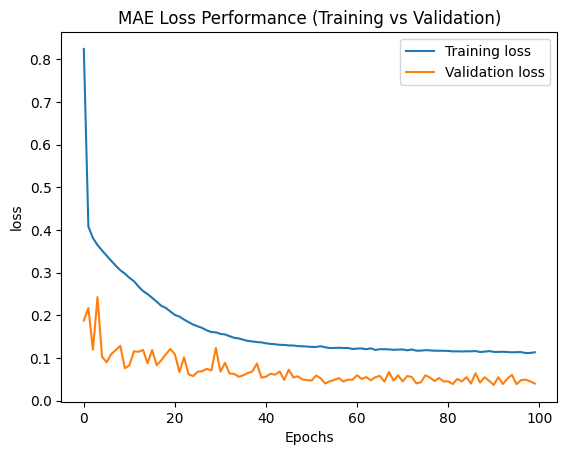

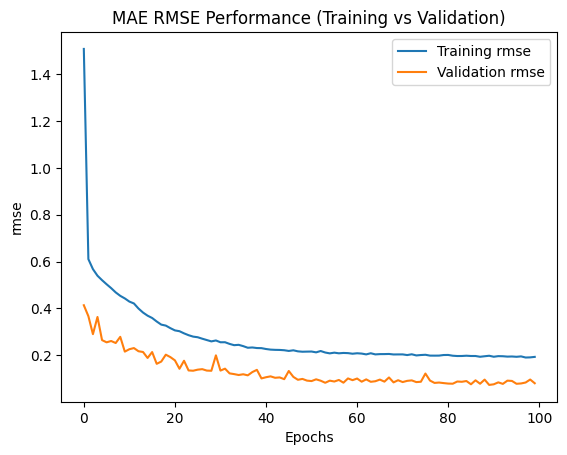

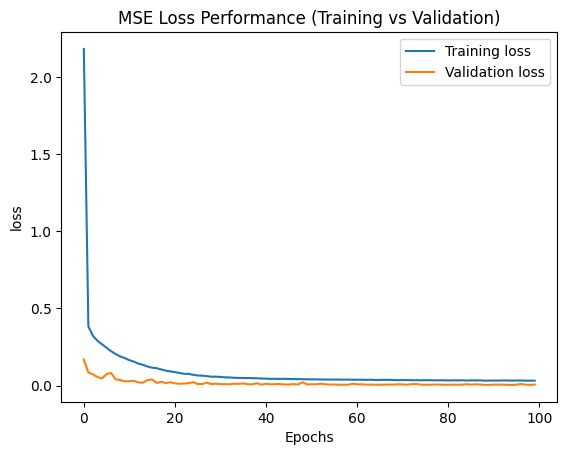

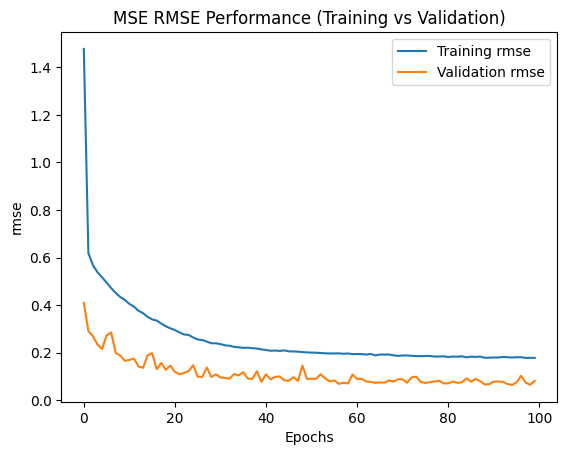

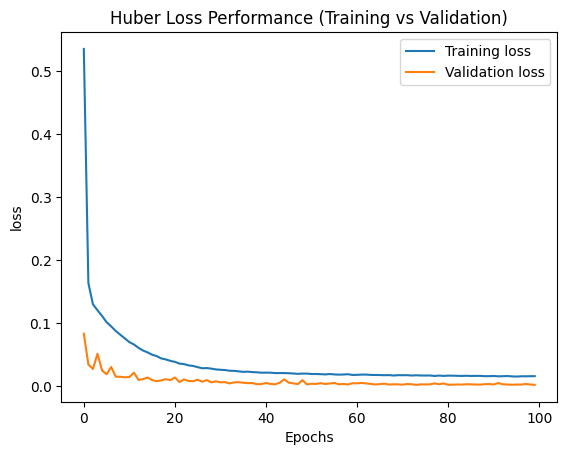

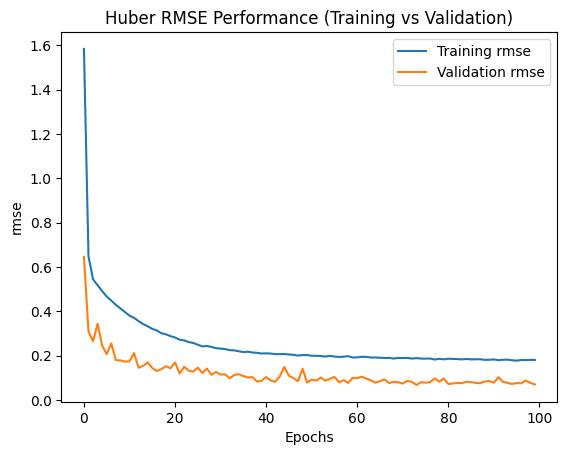

In [21]:
import matplotlib.pyplot as plt

# Train the models and record performance history
def build_and_train_model(loss_function, X_train_reshaped, y_train, X_test_reshaped, y_test):
    model = build_and_compile_model(loss_function)
    
    # Train the model and save the training history
    history = model.fit(
        X_train_reshaped, y_train, 
        epochs=100, batch_size=32, 
        validation_data=(X_test_reshaped, y_test), 
        verbose=1
    )
    
    return model, history

# Define a function to plot training and testing performance
def plot_training_testing_performance(history, metric, title):
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Assume you already split your data using KFold and have reshaped X_train_reshaped and X_test_reshaped

# Train models for each loss function and capture history
model_mae, history_mae = build_and_train_model(MeanAbsoluteError(), X_train_reshaped, y_train, X_test_reshaped, y_test)
model_mse, history_mse = build_and_train_model(MeanSquaredError(), X_train_reshaped, y_train, X_test_reshaped, y_test)
model_huber, history_huber = build_and_train_model(Huber(), X_train_reshaped, y_train, X_test_reshaped, y_test)

# Plot MAE performance
plot_training_testing_performance(history_mae, 'loss', 'MAE Loss Performance (Training vs Validation)')
plot_training_testing_performance(history_mae, 'rmse', 'MAE RMSE Performance (Training vs Validation)')

# Plot MSE performance
plot_training_testing_performance(history_mse, 'loss', 'MSE Loss Performance (Training vs Validation)')
plot_training_testing_performance(history_mse, 'rmse', 'MSE RMSE Performance (Training vs Validation)')

# Plot Huber performance
plot_training_testing_performance(history_huber, 'loss', 'Huber Loss Performance (Training vs Validation)')
plot_training_testing_performance(history_huber, 'rmse', 'Huber RMSE Performance (Training vs Validation)')


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2

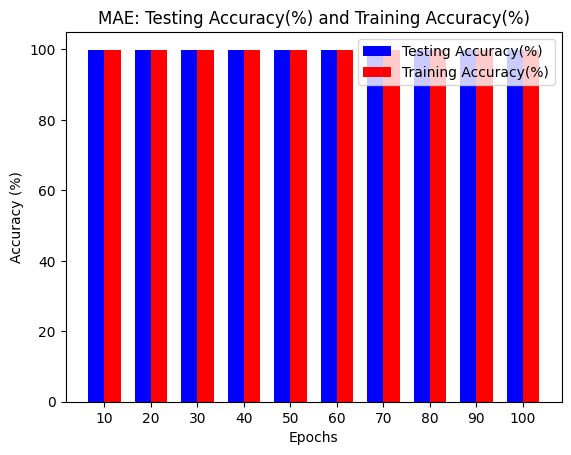

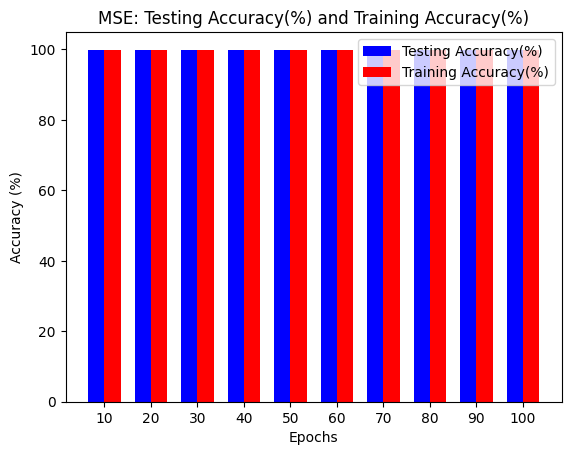

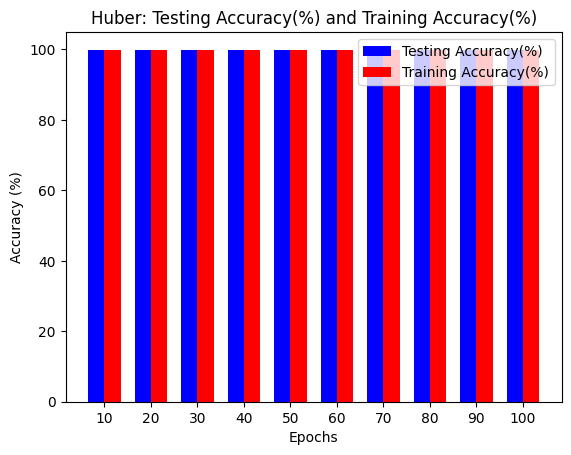

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Function to calculate training and validation R2 scores at intervals of 10 epochs
def calculate_accuracy_at_intervals(history, X_train_reshaped, y_train, X_test_reshaped, y_test, model, intervals=10):
    training_acc = []
    validation_acc = []
    epochs = list(range(intervals, len(history.history['loss']) + 1, intervals))
    
    for epoch in epochs:
        # Get model predictions for the current epoch
        y_train_pred = model.predict(X_train_reshaped)
        y_test_pred = model.predict(X_test_reshaped)
        
        # Calculate R2 score for training and testing sets
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        training_acc.append(train_r2 * 100)  # Convert to percentage
        validation_acc.append(test_r2 * 100)  # Convert to percentage
    
    return epochs, training_acc, validation_acc

# Calculate training and validation accuracy (R2 score) every 10 epochs
epochs_mae, train_acc_mae, val_acc_mae = calculate_accuracy_at_intervals(history_mae, X_train_reshaped, y_train, X_test_reshaped, y_test, model_mae)
epochs_mse, train_acc_mse, val_acc_mse = calculate_accuracy_at_intervals(history_mse, X_train_reshaped, y_train, X_test_reshaped, y_test, model_mse)
epochs_huber, train_acc_huber, val_acc_huber = calculate_accuracy_at_intervals(history_huber, X_train_reshaped, y_train, X_test_reshaped, y_test, model_huber)

# Example plot for MSE model accuracy comparison
def plot_training_testing_accuracy(epochs, train_acc, val_acc, title):
    bar_width = 0.35
    index = np.arange(len(epochs))
    
    fig, ax = plt.subplots()
    bar1 = ax.bar(index, val_acc, bar_width, label='Testing Accuracy(%)', color='b')
    bar2 = ax.bar(index + bar_width, train_acc, bar_width, label='Training Accuracy(%)', color='r')

    # Add some labels and title
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(epochs)
    ax.legend()

    plt.show()

# Plot accuracy comparison for MAE model
plot_training_testing_accuracy(epochs_mae, train_acc_mae, val_acc_mae, 'MAE: Testing Accuracy(%) and Training Accuracy(%)')

# Plot accuracy comparison for MSE model
plot_training_testing_accuracy(epochs_mse, train_acc_mse, val_acc_mse, 'MSE: Testing Accuracy(%) and Training Accuracy(%)')

# Plot accuracy comparison for Huber model
plot_training_testing_accuracy(epochs_huber, train_acc_huber, val_acc_huber, 'Huber: Testing Accuracy(%) and Training Accuracy(%)')
